# KRRPM Example

This notebook demonstrates the use of KRRPM.

It applies KRRPM to the dataset [QSAR-TID-13000](https://www.openml.org/d/3601) available on OpenML.
The dataset has 3459 entries with 1024 features. Each entry corresponds to a chemical compound. The labels correspond to the measured activity of the compounds on a biological target.

We shuffle and split the dataset into a training set and a test set.

We train KRRPM on the observations in the training set. We predict the distribution of the label given a test object.

We then verify that the calibration property is satisfied within statistical fluctuation, by showing that for every chosen confidence level we can identify intervals such that the actual labels are within the interval with relative frequency close to the chosen confidence.

In [1]:
test_fraction = 0.25    # Fraction of the dataset used as test set (the balance is used as training set)
shuffle_split_seed = 1  # random state for shuffling and splitting the dataset

a=0.05                  # Regularization parameter
kernel_type = "rbf"     # "rbf" or "linear"
rbf_gamma = 0.01        # RBF kernel parameter

In [2]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml

In [3]:
import matplotlib.pyplot as plt

In [4]:
qsar = fetch_openml("QSAR-TID-13000")

In [5]:
qsar.data

<3459x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 197174 stored elements in Compressed Sparse Row format>

In [6]:
def compute_intervals_krrpm(Cs,conf=0.8):
    highs = np.empty(len(Cs))
    lows = np.empty(len(Cs))
    for i,c in enumerate(Cs):
        median_index = int(len(c)*0.5)       
        prob_per_val = 1/len(c)    # Assuming same "width" per CPD strip
        high_end_index = int(median_index + 0.5*conf/prob_per_val)
        low_end_index = int(median_index - 0.5*conf/prob_per_val)
        highs[i] = c[high_end_index]
        lows[i] = c[low_end_index]
    return lows,highs


def createPredDataFrame(y,cs):
    df = pd.DataFrame(dict(Measured=y))

    for i,cf in enumerate(np.arange(0.1, 1, 0.1)):
        l,h = compute_intervals_krrpm(cs, cf)
        df["confidence_"+str(i)] = cf*np.ones(shape=(len(l)))
        df["range_lower_"+str(i)] = l
        df["range_upper_"+str(i)] = h
        
    return df

def compute_validity_fixedConf(ps):
    confRange = list(range(0,9))
    hits = np.zeros(shape=len(confRange))
    counts = np.zeros(shape=len(confRange))
    for cnfIdx in confRange:
        for y,l,h in zip(ps['Measured'],
                         ps['range_lower_'+str(cnfIdx)],
                         ps['range_upper_'+str(cnfIdx)]):
            counts[cnfIdx] += 1
            hits[cnfIdx]+= (l < y < h)
    
    return counts,hits

In [7]:
import KRRPM

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_x, test_x, train_y, test_y = train_test_split(qsar.data, qsar.target, 
                                                    test_size=test_fraction, random_state=shuffle_split_seed)

In [10]:
krrpm = KRRPM.KRRPM(a=a, kernel=kernel_type, kernel_kwargs=dict(gamma=rbf_gamma))

In [11]:
krrpm.fit(train_x, train_y)
krrpm.predict(test_x);

In [12]:
pds = krrpm.predicted_distributions  # Let's fetch the predicted distributions for the labels of the test objects

Let's plot some of the predictive distributions we have just computed 

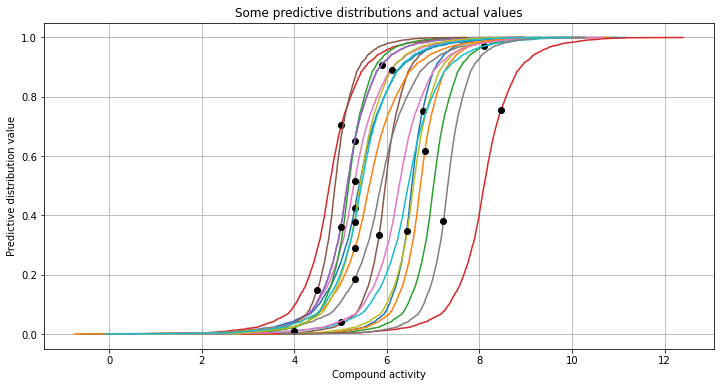

In [13]:
f,ax = plt.subplots(1,1,figsize=(12,6))

pds_n = 20

for pr,y in zip(pds[:pds_n],test_y[:pds_n]):
    ax.plot(pr, np.linspace(0,1,len(pr)))
    ax.plot(y, np.searchsorted(pr, y) / len(pr), "ko")

ax.set_xlabel("Compound activity")
ax.set_ylabel("Predictive distribution value")

ax.set_title("Some predictive distributions and actual values")

ax.grid()

Let's verify that the PDs exhibit the validity property.

For different values of confidence, we compute the prediction intervals resulting from the predictive distributions.
We then compute the fraction of the test examples for which the actual label is within the interval.
The fraction must be close to the confidence.

In addition, we show the distribution of the width of the prediction intervals.

In [14]:
res_df = createPredDataFrame(test_y, pds)
for i in map(str,range(9)):
    res_df[f'width_{i}'] = res_df[f"range_upper_{i}"] - res_df[f"range_lower_{i}"]

In [15]:
counts,hits = compute_validity_fixedConf(res_df)

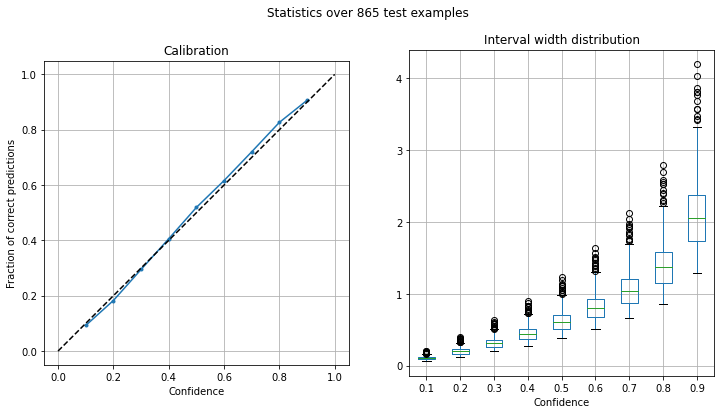

In [16]:
xs = np.arange(0.1, 1, 0.1)

f,axs = plt.subplots(1,2,figsize=(12,6))

ax = axs[0]
ax.plot(xs,(hits/counts).ravel(),'.-')
ax.plot([0,1],[0,1],"k--")
ax.set_aspect(1)
ax.grid()
ax.set_ylabel('Fraction of correct predictions')
ax.set_xlabel("Confidence")
ax.set_title("Calibration")

renaming = {f'width_{i}': f'{cf:0.1f}' for i,cf in enumerate(np.arange(0.1, 1, 0.1))}
res_df.rename(columns=renaming).boxplot(ax=axs[1],
                                        column=[f"{cf:0.1f}" for cf in np.arange(0.1,1,0.1)]);
axs[1].set_title("Interval width distribution")
axs[1].set_xlabel("Confidence")
axs[1].set_ylabel


    
f.suptitle('Statistics over {0} test examples'.format(test_x.shape[0]));